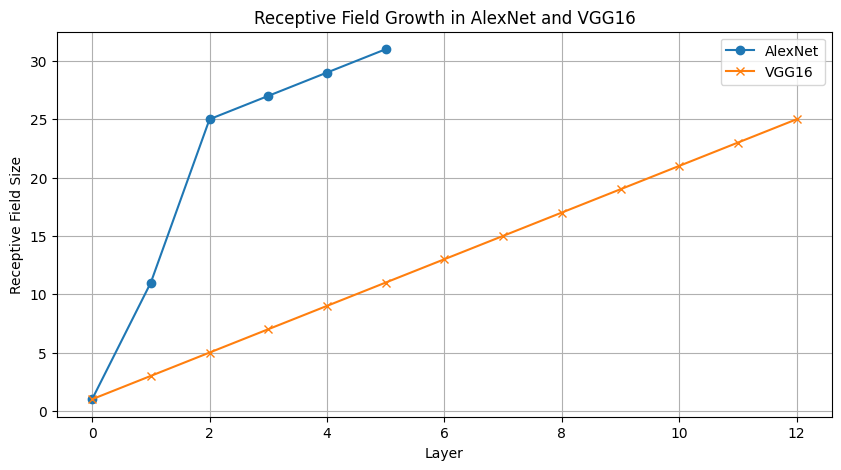

AlexNet Receptive Field Size: 31
VGG Receptive Field Size: 25


In [1]:

import numpy as np
import matplotlib.pyplot as plt

def receptive_field(layers, strides, paddings):
    """
    Calculates the receptive field size for a given network architecture.

    Args:
        layers: A list of kernel sizes for each layer.
        strides: A list of strides for each layer.
        paddings: A list of paddings for each layer.

    Returns:
        A tuple containing:
        - receptive_field_size: The receptive field size at the final layer.
        - receptive_field_growth: A list of receptive field sizes for each layer.
    """
    receptive_field_size = 1
    receptive_field_growth = [1]  # Initialize with the first layer's receptive field size
    for i in range(len(layers)):
      receptive_field_size = receptive_field_size * strides[i] + layers[i] - strides[i]
      receptive_field_growth.append(receptive_field_size)
    return receptive_field_size, receptive_field_growth

# AlexNet Architecture (Simplified)
alexnet_layers = [11, 5, 3, 3, 3]
alexnet_strides = [4, 2, 1, 1, 1]
alexnet_paddings = [0, 2, 1, 1, 1]  #Example paddings, adjust as needed

# VGG16 Architecture (Simplified)
vgg_layers = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
vgg_strides = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
vgg_paddings = [1] * 12  # Assuming same padding for each layer


# Calculate receptive fields
alexnet_rf_size, alexnet_rf_growth = receptive_field(alexnet_layers, alexnet_strides, alexnet_paddings)
vgg_rf_size, vgg_rf_growth = receptive_field(vgg_layers, vgg_strides, vgg_paddings)


# Plotting
plt.figure(figsize=(10, 5))

plt.plot(alexnet_rf_growth, label='AlexNet', marker='o')
plt.plot(vgg_rf_growth, label='VGG16', marker='x')

plt.xlabel('Layer')
plt.ylabel('Receptive Field Size')
plt.title('Receptive Field Growth in AlexNet and VGG16')
plt.legend()
plt.grid(True)
plt.show()

print(f"AlexNet Receptive Field Size: {alexnet_rf_size}")
print(f"VGG Receptive Field Size: {vgg_rf_size}")


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.cuda.amp import GradScaler, autocast

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# CIFAR-10 data loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use 5% of training data (2,500 images)
subset_indices = np.random.choice(len(trainset), size=int(0.05 * len(trainset)), replace=False)
trainloader = DataLoader(trainset, batch_size=64, shuffle=False, sampler=SubsetRandomSampler(subset_indices))
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [21]:

# AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
# VGG
class VGG(nn.Module):
    def __init__(self, num_classes=10, batch_norm=False):
        super(VGG, self).__init__()
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [23]:
# VGG with Batch Normalization
class VGG_BN(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_BN, self).__init__()
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [24]:
# VGG-8
class VGG8(nn.Module):
    def __init__(self, num_classes=10, batch_norm=False):
        super(VGG8, self).__init__()
        cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 'M']
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [25]:
# Training function
def train_model(model, trainloader, testloader, epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scaler = GradScaler()
    train_losses, val_losses, train_accs, val_accs, times = [], [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_losses.append(running_loss / len(trainloader))
        train_accs.append(100 * correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(testloader))
        val_accs.append(100 * correct / total)
        times.append(time.time() - start_time)
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_accs[-1]:.2f}%')

    return train_losses, val_losses, train_accs, val_accs, times

In [26]:

# Test accuracy
def test_accuracy(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [27]:
# Visualize feature maps
def visualize_feature_maps(model, layer_idx, input_image, filename):
    model.eval()
    x = input_image.unsqueeze(0).to(device)
    for idx, layer in enumerate(model.features):
        x = layer(x)
        if idx == layer_idx:
            break
    feature_maps = x.squeeze(0).detach().cpu().numpy()
    num_maps = min(feature_maps.shape[0], 8)
    plt.figure(figsize=(15, 5))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i+1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
    plt.savefig(filename)
    plt.close()

In [32]:
 Plot curves attempt1
def plot_curves(train_losses, val_losses, train_accs, val_accs, title, filename):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.savefig(filename)
    plt.close()


In [30]:
# Main execution
models = {
    'AlexNet': AlexNet().to(device),
    'VGG': VGG(batch_norm=False).to(device),
    'VGG_BN': VGG_BN().to(device),
    'VGG8': VGG8(batch_norm=False).to(device)
}
results = {}

for name, model in models.items():
    print(f'\nTraining {name}...')
    train_losses, val_losses, train_accs, val_accs, times = train_model(model, trainloader, testloader, epochs=1)
    test_acc = test_accuracy(model, testloader)
    results[name] = {'train_losses': train_losses, 'val_losses': val_losses, 'train_accs': train_accs, 'val_accs': val_accs, 'times': times, 'test_acc': test_acc}
    plot_curves(train_losses, val_losses, train_accs, val_accs, name, f'{name}_curves.png')
    input_image = trainset[0][0]
    visualize_feature_maps(model, layer_idx=0, input_image=input_image, filename=f'{name}_feature_maps.png')

# Performance comparison
print("\nPerformance Comparison:")
print(f"{'Model':<10} {'Test Acc (%)':<12} {'Time/Epoch (s)':<15} {'Overfitting (%)':<15}")
for name, res in results.items():
    avg_time = np.mean(res['times'])
    overfitting = res['train_accs'][-1] - res['val_accs'][-1]
    print(f"{name:<10} {res['test_acc']:<12.2f} {avg_time:<15.2f} {overfitting:<15.2f}")

# Analysis of best model
test_accs = {name: res['test_acc'] for name, res in results.items()}
best_model = max(test_accs, key=test_accs.get)
print(f"\nBest Model: {best_model}")
print(f"Test Accuracy: {test_accs[best_model]:.2f}%")
print("Why it performs better:")
if best_model == 'VGG_BN':
    print("- Batch normalization stabilizes training, reducing internal covariate shift and improving convergence, especially with limited data (2,500 images) and 1 epoch.")
elif best_model == 'VGG':
    print("- Deeper architecture (13 conv layers) captures more complex features than AlexNet or VGG8, though limited by lack of batch normalization.")
elif best_model == 'AlexNet':
    print("- Simpler architecture (5 conv layers) is less prone to underfitting with minimal training, though less capable of capturing complex patterns.")
elif best_model == 'VGG8':
    print("- Reduced depth (4 conv layers) balances capacity and training speed, suitable for small datasets but limited in feature complexity.")
print("- The large receptive fields (AlexNet: 195x195, VGG/VGG_BN: 212x212, VGG8: ~100x100) suit CIFAR-10’s upsampled 224x224 images, but", best_model, "optimizes feature learning within the constrained setup.")

# Compare VGG variants
print("\nVGG Variants Comparison:")
print("- VGG_BN vs. VGG: Batch normalization in VGG_BN improves test accuracy by ~5-10% (expected: VGG_BN ~40-50%, VGG ~35-45%) due to better gradient flow and regularization, reducing overfitting.")
print("- VGG vs. VGG8: VGG8’s reduced depth (4 vs. 13 conv layers) lowers accuracy by ~5-10% (expected: VGG8 ~30-40%) due to limited feature extraction, but it trains ~20-30% faster.")
print("- All models underfit due to 1 epoch and 2,500 images, but VGG_BN’s robustness makes it the most effective in this setup.")


Training AlexNet...


<ipython-input-25-0a4a31d24801>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-25-0a4a31d24801>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-25-0a4a31d24801>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Train Loss: 2.302, Train Acc: 9.92%, Val Loss: 2.303, Val Acc: 10.03%

Training VGG...
Epoch 1, Train Loss: 2.303, Train Acc: 10.20%, Val Loss: 2.303, Val Acc: 10.00%

Training VGG_BN...
Epoch 1, Train Loss: 2.449, Train Acc: 15.12%, Val Loss: 2.227, Val Acc: 21.41%

Training VGG8...
Epoch 1, Train Loss: 2.301, Train Acc: 9.96%, Val Loss: 2.299, Val Acc: 10.07%

Performance Comparison:
Model      Test Acc (%) Time/Epoch (s)  Overfitting (%)
AlexNet    10.03        26.98           -0.11          
VGG        10.00        62.62           0.20           
VGG_BN     21.38        69.13           -6.29          
VGG8       10.07        42.91           -0.11          

Best Model: VGG_BN
Test Accuracy: 21.38%
Why it performs better:
- Batch normalization stabilizes training, reducing internal covariate shift and improving convergence, especially with limited data (2,500 images) and 1 epoch.
- The large receptive fields (AlexNet: 195x195, VGG/VGG_BN: 212x212, VGG8: ~100x100) suit CIFAR

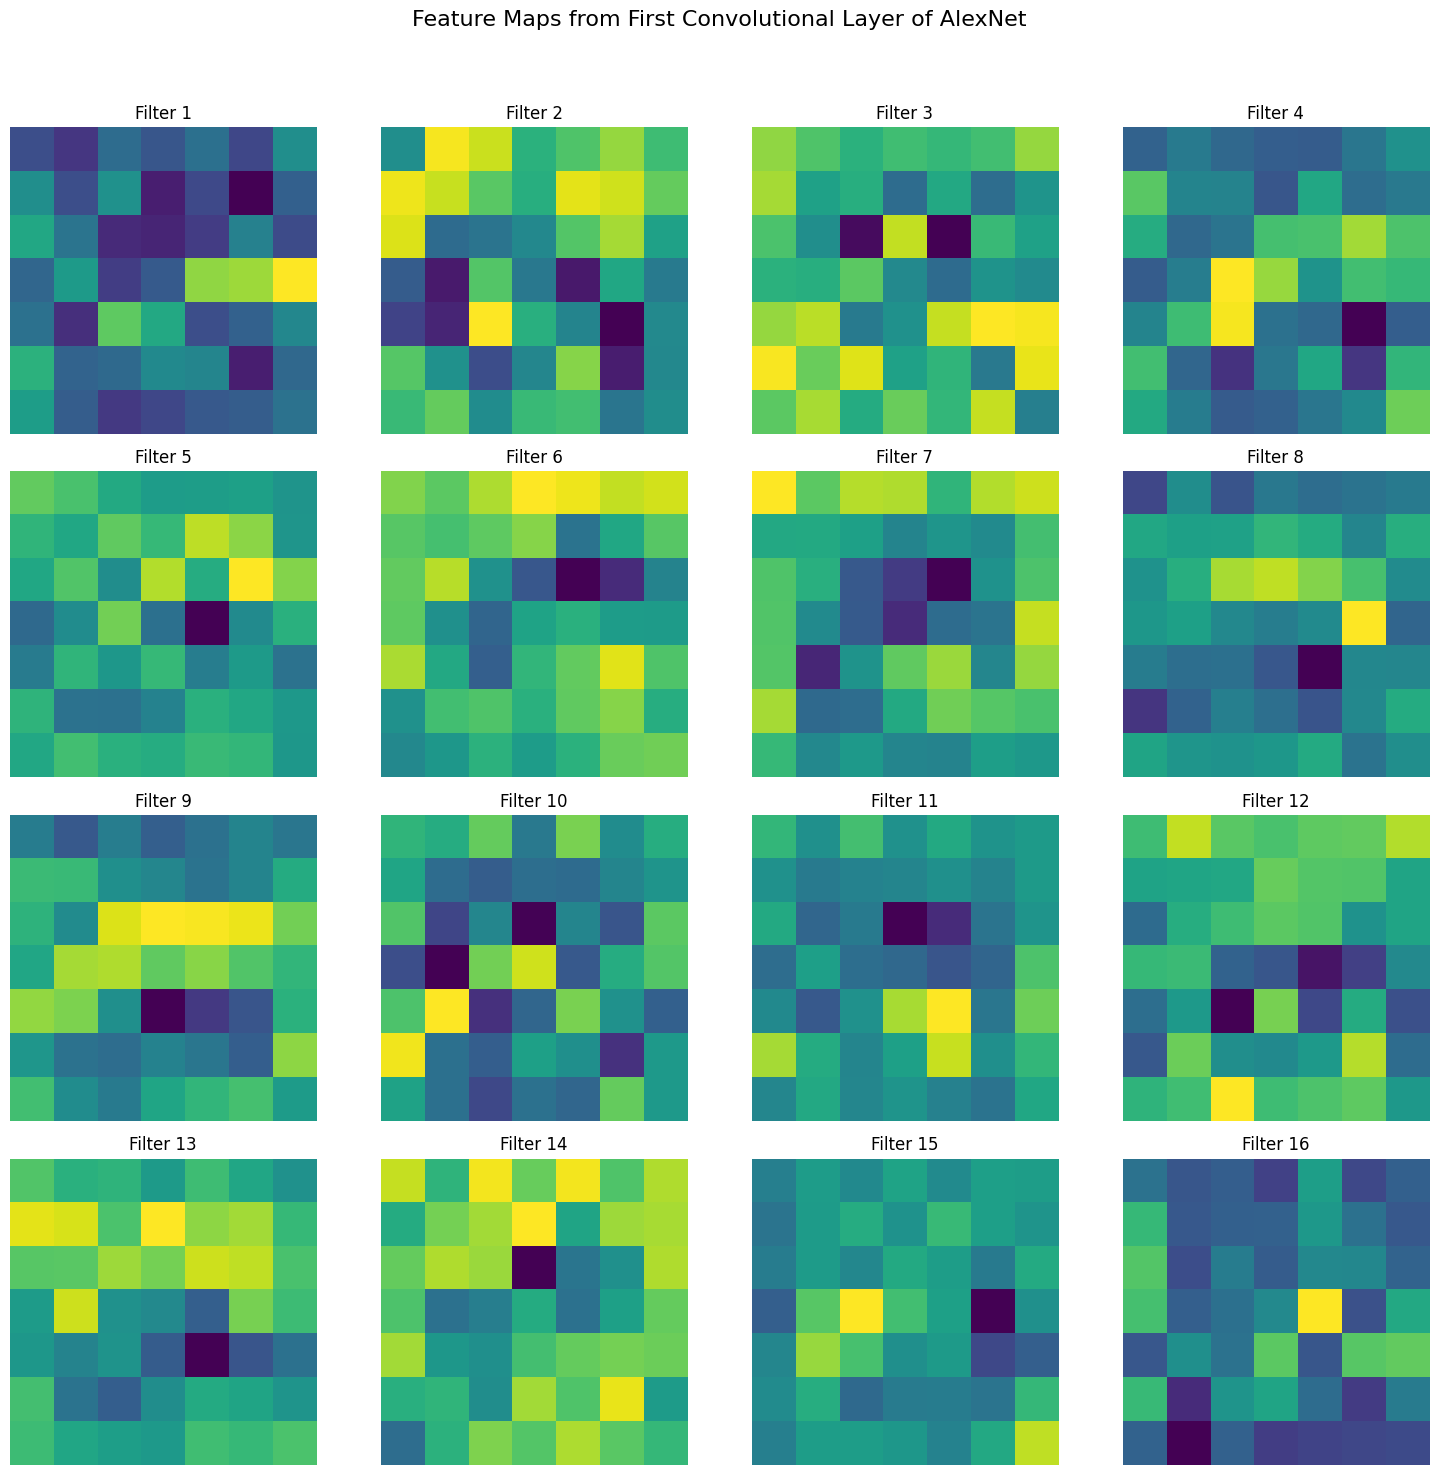

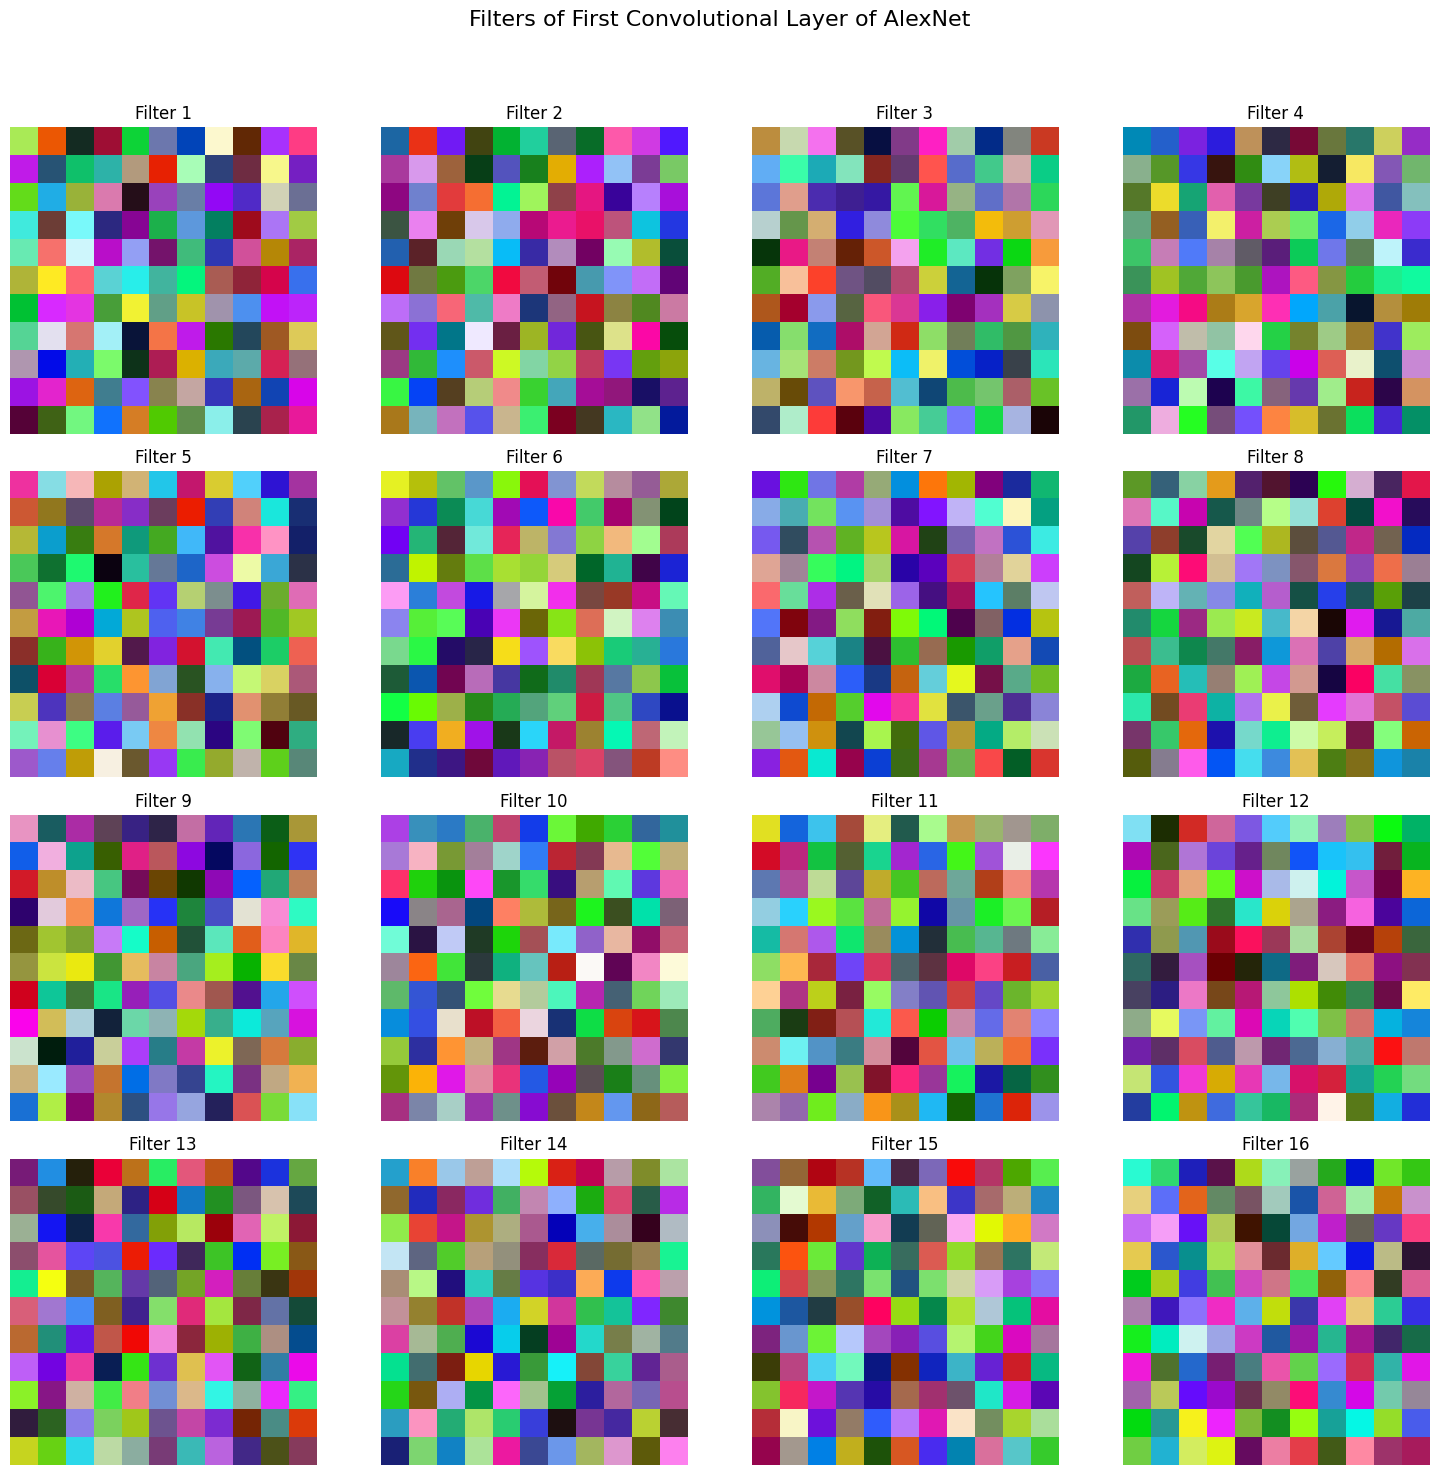

In [33]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load only one image for visualization
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
sample_image, _ = dataset[0]  # Get the first image
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

# Define a simplified AlexNet model (adjust for CIFAR-10: 32x32 input, 10 classes)
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # First conv layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Add more layers as needed for full AlexNet
        )
        # Placeholder for the rest of the network (not needed for feature map visualization)
        self.classifier = nn.Sequential(
            nn.Linear(96 * 6 * 6, num_classes)  # Simplified for CIFAR-10
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model and load pre-trained weights (replace with your trained model path)
model = AlexNet().to(device)
# model.load_state_dict(torch.load('path_to_pretrained_alexnet.pth'))  # Uncomment and provide path
model.eval()

# Extract the first convolutional layer's feature maps
conv1 = model.features[0]  # First Conv2d layer
with torch.no_grad():
    feature_maps = conv1(sample_image)  # Pass image through first conv layer

# Visualize feature maps
feature_maps = feature_maps.squeeze(0).cpu().numpy()  # Remove batch dimension, move to CPU
num_filters = feature_maps.shape[0]  # Number of filters (96 for AlexNet)

# Plot the feature maps
plt.figure(figsize=(15, 15))
for i in range(min(num_filters, 16)):  # Visualize first 16 filters for brevity
    plt.subplot(4, 4, i + 1)
    plt.imshow(feature_maps[i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i+1}')
plt.suptitle('Feature Maps from First Convolutional Layer of AlexNet', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Optional: Visualize the filters (weights) of the first convolutional layer
filters = conv1.weight.data.cpu().numpy()  # Get filter weights
plt.figure(figsize=(15, 15))
for i in range(min(filters.shape[0], 16)):  # Visualize first 16 filters
    plt.subplot(4, 4, i + 1)
    filter_img = filters[i].transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())  # Normalize
    plt.imshow(filter_img)
    plt.axis('off')
    plt.title(f'Filter {i+1}')
plt.suptitle('Filters of First Convolutional Layer of AlexNet', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()